In [1]:
'''from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')'''


"from google.colab import drive\n\n# Mount Google Drive\ndrive.mount('/content/drive')"

In [2]:
# Import necessary libraries
import os
import numpy as np
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense


os.environ['KMP_DUPLICATE_LIB_OK']='True'


2024-03-13 20:24:48.055182: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-13 20:24:48.055248: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-13 20:24:48.055301: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-13 20:24:48.066558: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
file_paths = os.listdir('Data2')
len(file_paths)

94

In [4]:
# Define paths to your data folders
data_dir = 'Data2'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

In [5]:
#Deleting duplicate images function

import os
from PIL import Image
import hashlib

# Function to remove duplicate images based on hash comparison
def remove_duplicates(images_dir):
    # Create a dictionary to store hashes of images
    hash_dict = {}

    # Iterate through all images in the directory
    for root, dirs, files in os.walk(images_dir):
        for file in files:
            file_path = os.path.join(root, file)

            # Calculate the hash of the image file
            with open(file_path, 'rb') as f:
                file_hash = hashlib.md5(f.read()).hexdigest()

            # Check if the hash already exists in the dictionary
            if file_hash in hash_dict:
                # If hash exists, remove the duplicate image
                os.remove(file_path)
                print(f"Duplicate image removed: {file_path}")
            else:
                # If hash does not exist, add it to the dictionary
                hash_dict[file_hash] = file_path

# Function to remove corrupted images
def remove_corrupted_images(images_dir):
    # Iterate through all images in the directory
    for root, dirs, files in os.walk(images_dir):
        for file in files:
            file_path = os.path.join(root, file)

            try:
                # Attempt to open the image file
                with Image.open(file_path) as img:
                    img.verify()  # Verify if the image is valid
            except (IOError, SyntaxError) as e:
                # If image cannot be opened or is corrupted, remove it
                os.remove(file_path)
                print(f"Corrupted image removed: {file_path}")




In [6]:
# Example usage:
data_dir = 'Data2'

# Step 1: Data Cleaning
remove_duplicates(data_dir)
remove_corrupted_images(data_dir)

In [19]:
# Define image size and batch size
img_size = (75, 75)  # Adjust image size
#img_size = (64, 64)  # Adjust image size
batch_size = 8


from keras.applications import VGG16, InceptionV3, ResNet50

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))

model = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dense(94, activation='softmax')
])


for layer in base_model.layers:
    layer.trainable = False

# Optionally, unfreeze some top layers for fine-tuning
for layer in base_model.layers[-4:]:
    layer.trainable = True

94765736/94765736 [==============================] - 41s 0us/step


In [20]:
from keras.callbacks import EarlyStopping, LearningRateScheduler

early_stopping = EarlyStopping(patience=3, restore_best_weights=True)


In [21]:
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)


train_generator = datagen.flow_from_directory(
        data_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='training',
        shuffle=True)

test_generator = datagen.flow_from_directory(
        data_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation',
        shuffle=False)  # No need to shuffle the validation data


data_dir = 'Data2'

# Create ImageDataGenerator with automatic split and classes=None
# datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# train_generator = datagen.flow_from_directory(
#         data_dir,
#         target_size=img_size,
#         batch_size=batch_size,
#         class_mode='sparse',  # Use 'sparse' for multi-class classification
#         subset='training',
#         shuffle=True)

# test_generator = datagen.flow_from_directory(
#         data_dir,
#         target_size=img_size,
#         batch_size=batch_size,
#         class_mode='sparse',  # Use 'sparse' for multi-class classification
#         subset='validation',
#         shuffle=False)


Found 3859 images belonging to 94 classes.
Found 924 images belonging to 94 classes.


In [22]:
# Compile the model with 'sparse_categorical_crossentropy' as the loss function

from keras.optimizers import Adagrad
model.compile(optimizer=Adagrad(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])




In [23]:
epochs = 60  # Adjust the number of epochs

def step_decay(epoch):
    initial_lr = 0.001  # Initial learning rate
    drop = 0.5  # Learning rate drop factor
    epochs_drop = 5  # Number of epochs after which learning rate will drop
    new_lr = initial_lr * (drop ** (epoch // epochs_drop))
    return new_lr

learnRateSch = LearningRateScheduler(step_decay)

history = model.fit(
      train_generator,
      steps_per_epoch=train_generator.samples // batch_size,
      epochs=epochs,
      validation_data=test_generator,
      validation_steps=test_generator.samples // batch_size,
      callbacks=[learnRateSch, early_stopping])

Epoch 1/60
482/482 [==============================] - 13s 22ms/step - loss: 3.8075 - accuracy: 0.1236 - val_loss: 3.5542 - val_accuracy: 0.1446 - lr: 0.0010
Epoch 2/60
482/482 [==============================] - 8s 17ms/step - loss: 3.4039 - accuracy: 0.1768 - val_loss: 3.4219 - val_accuracy: 0.1761 - lr: 0.0010
Epoch 3/60
482/482 [==============================] - 9s 18ms/step - loss: 3.2005 - accuracy: 0.2129 - val_loss: 3.3553 - val_accuracy: 0.1826 - lr: 0.0010
Epoch 4/60
482/482 [==============================] - 9s 18ms/step - loss: 3.0348 - accuracy: 0.2389 - val_loss: 3.2624 - val_accuracy: 0.2022 - lr: 0.0010
Epoch 5/60
482/482 [==============================] - 9s 19ms/step - loss: 2.9020 - accuracy: 0.2664 - val_loss: 3.2538 - val_accuracy: 0.2054 - lr: 0.0010
Epoch 6/60
482/482 [==============================] - 9s 18ms/step - loss: 2.7164 - accuracy: 0.3082 - val_loss: 3.1378 - val_accuracy: 0.2478 - lr: 5.0000e-04
Epoch 7/60
482/482 [==============================] - 9s 19

KeyboardInterrupt: 

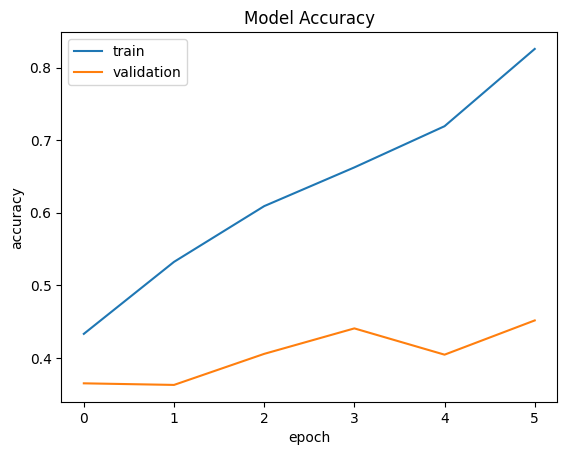

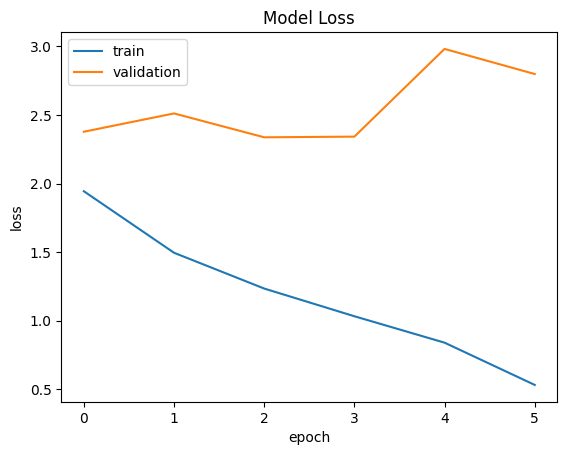

In [20]:
def plotter(history):
    import matplotlib.pyplot as plt
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    

plotter(history)
### Printing F1 score
from sklearn.metrics import f1_score
import numpy as np
test_generator.reset()
Y_pred = model.predict(test_generator, test_generator.samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('F1 score:', f1_score(test_generator.classes, y_pred, average='weighted'))

In [ ]:

# Evaluate the model
loss, accuracy = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print("Test Accuracy:", accuracy)

61/61 [==============================] - 52s 846ms/step - loss: 0.4120 - accuracy: 0.8453
Test Accuracy: 0.8452869057655334


In [ ]:
from keras.preprocessing import image
import numpy as np

# Load a sample image
sample_img_path = '/content/drive/My Drive/OIP.jpg'  # Path to your sample image
img = image.load_img(sample_img_path, target_size=img_size)


In [ ]:
# Preprocess the image
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # Rescale pixel values


In [ ]:

# Use the trained model to make predictions
predictions = model.predict(img_array)


1/1 [==============================] - 0s 380ms/step


In [ ]:
# Decode the predictions
predicted_class = np.argmax(predictions[0])
class_labels = train_generator.class_indices
predicted_label = [k for k, v in class_labels.items() if v == predicted_class][0]

# Print the predicted class label
print("Predicted Class:", predicted_label)

Predicted Class: Sedimentary
